In [ ]:
# Step 1: Paths & Imports
import os, cv2
import numpy as np
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
# Base path setup
BASE_DIR = Path(os.getcwd()).parent  
xml_file1 = BASE_DIR / "data" / "annotation_batch" / "annotations.xml"
xml_file2 = BASE_DIR / "data" / "annotation_batch" / "annotations 2.xml"
images_dir = BASE_DIR / "data" / "annotation_batch"
csv_dir = images_dir
csv_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Step 2: Parse XML helper — with label-based mapping

LABEL_MAP = {
    "L_femoral_head_center": ("L_FHC_x", "L_FHC_y"),
    "R_femoral_head_center": ("R_FHC_x", "R_FHC_y"),
    "L_cranial_acetabular_rim": ("L_CAR_x", "L_CAR_y"),
    "R_cranial_acetabular_rim": ("R_CAR_x", "R_CAR_y"),
}

def parse_cvat_points_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    records = []

    for image_tag in root.findall("image"):
        img_name = image_tag.attrib["name"]
        w = float(image_tag.attrib["width"])
        h = float(image_tag.attrib["height"])
        pts_tags = image_tag.findall("points")

        coords = {col: None for col_pair in LABEL_MAP.values() for col in col_pair}

        if len(pts_tags) == 1:  
            coords_strs = pts_tags[0].attrib["points"].split(";")
            if len(coords_strs) != 4:
                continue
            # Assign in fixed order: [L_FHC, R_FHC, L_CAR, R_CAR]
            ordered_labels = [
                "L_femoral_head_center",
                "R_femoral_head_center",
                "L_cranial_acetabular_rim",
                "R_cranial_acetabular_rim"
            ]
            for label, coord_str in zip(ordered_labels, coords_strs):
                x_str, y_str = coord_str.split(",")
                norm_x, norm_y = float(x_str)/w, float(y_str)/h
                x_col, y_col = LABEL_MAP[label]
                coords[x_col] = norm_x
                coords[y_col] = norm_y

        elif len(pts_tags) == 4:
            # Four separate tags — use label field directly
            for pt in pts_tags:
                label = pt.attrib["label"]
                if label not in LABEL_MAP:
                    continue
                x_str, y_str = pt.attrib["points"].split(",")
                norm_x, norm_y = float(x_str)/w, float(y_str)/h
                x_col, y_col = LABEL_MAP[label]
                coords[x_col] = norm_x
                coords[y_col] = norm_y

        # Only keep if all 8 coords are present
        if all(v is not None for v in coords.values()):
            records.append({"image_name": img_name, **coords})

    return pd.DataFrame(records, columns=["image_name"] + [c for pair in LABEL_MAP.values() for c in pair])


In [ ]:
# Step 3: Parse & Merge XMLs → CSV
df1 = parse_cvat_points_xml(xml_file1)
df2 = parse_cvat_points_xml(xml_file2)

df_all = pd.concat([df1, df2], ignore_index=True)
df_all = df_all.drop_duplicates(subset=["image_name"]).reset_index(drop=True)

assert len(df_all) == 98, f"Expected 98 annotations, got {len(df_all)}"

merged_csv_path = csv_dir / "keypoints_normalized_FIXED.csv"
df_all.to_csv(merged_csv_path, index=False)
print(f"✅ Saved merged CSV (label‑based mapping): {merged_csv_path}")
print(df_all.sample(5))

✅ Saved merged CSV (label‑based mapping): /Users/aryan078/Desktop/CHD_project/outputs/csv/keypoints_normalized_FIXED.csv
     image_name   L_FHC_x   L_FHC_y   R_FHC_x   R_FHC_y   L_CAR_x   L_CAR_y  \
44  30_hip0.jpg  0.393750  0.427539  0.623242  0.421094  0.384180  0.403711   
96  97_hip0.jpg  0.421094  0.708008  0.643164  0.687891  0.408594  0.669141   
82  81_hip0.jpg  0.397656  0.444727  0.629102  0.420508  0.375977  0.418750   
85  85_hip0.jpg  0.335352  0.471875  0.689844  0.435937  0.326562  0.433594   
92  92_hip0.jpg  0.388672  0.390430  0.662695  0.384570  0.378711  0.358008   

     R_CAR_x   R_CAR_y  
44  0.630469  0.395508  
96  0.649609  0.648242  
82  0.638086  0.393359  
85  0.683008  0.407031  
92  0.671094  0.351172  


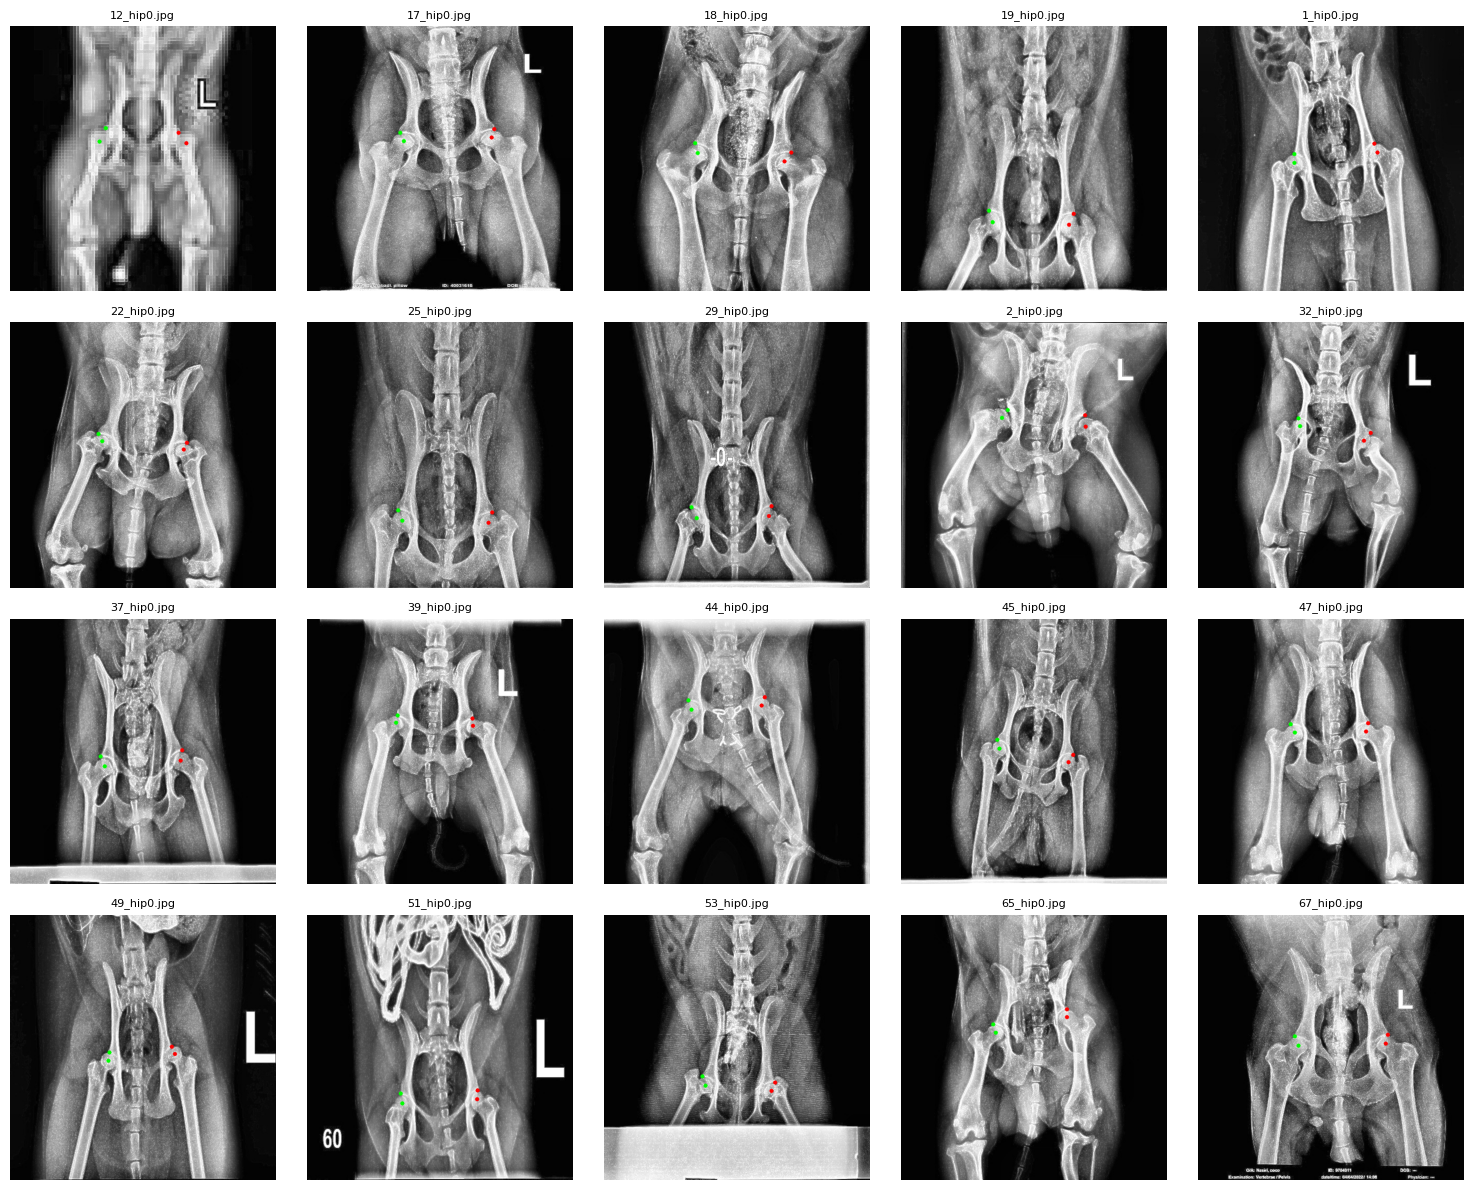

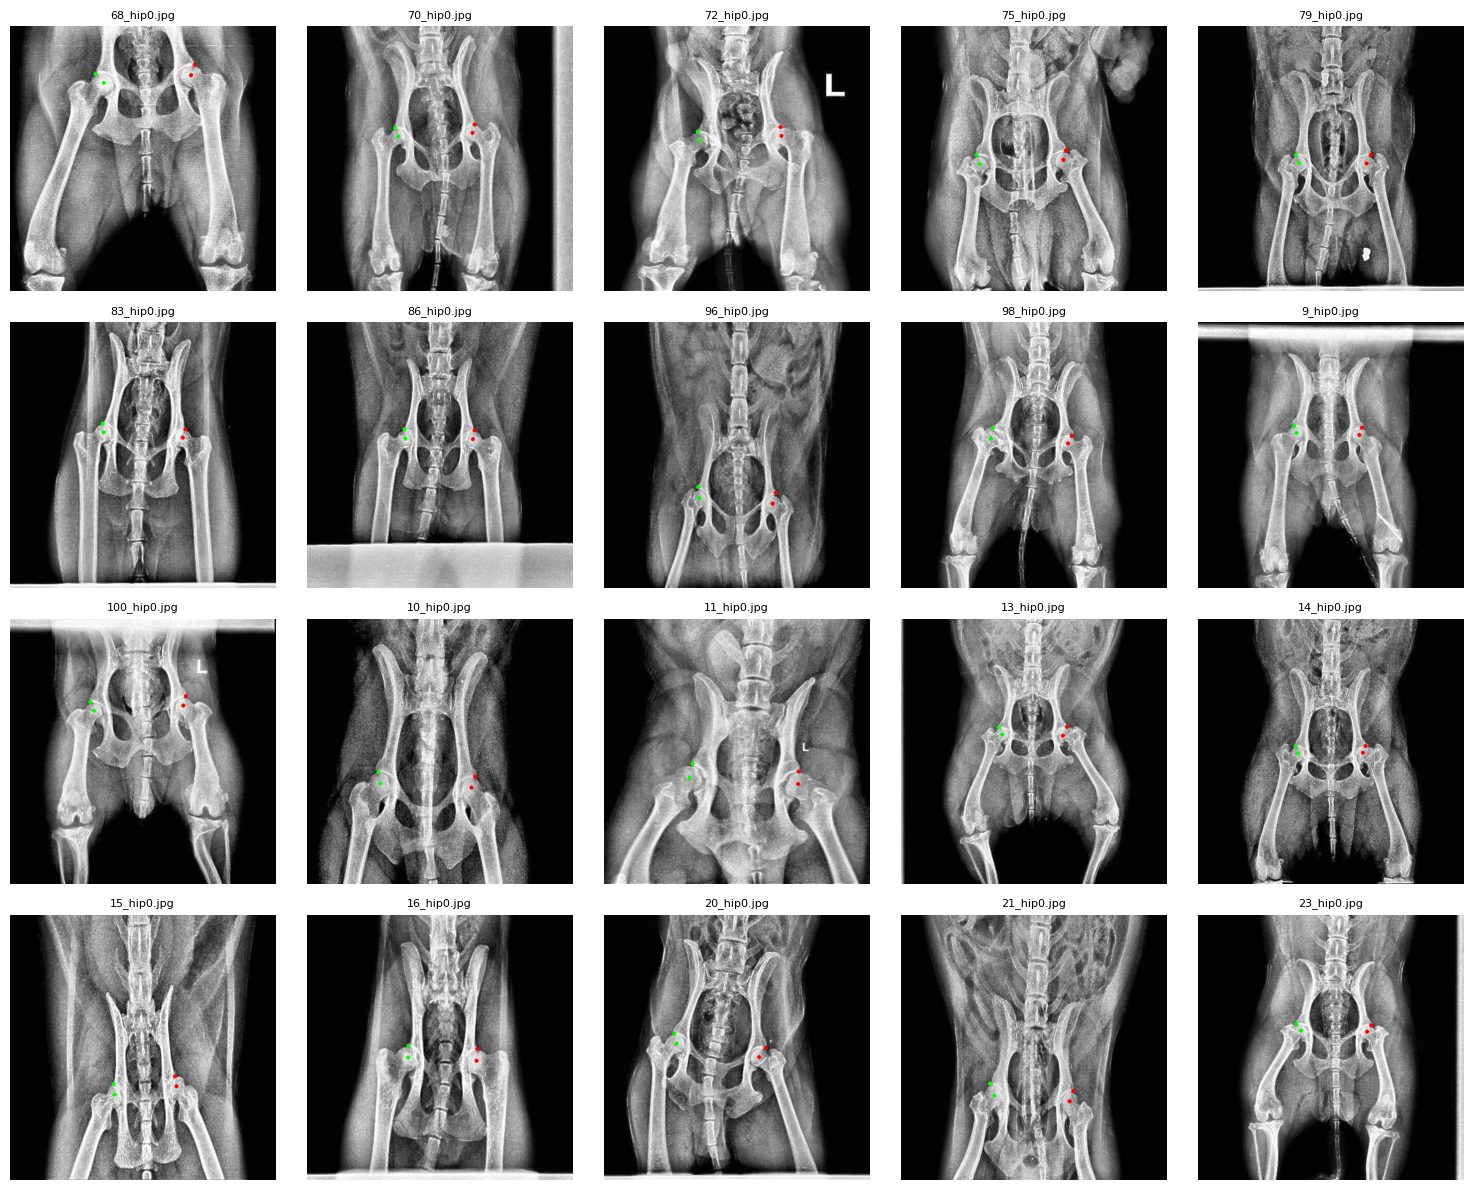

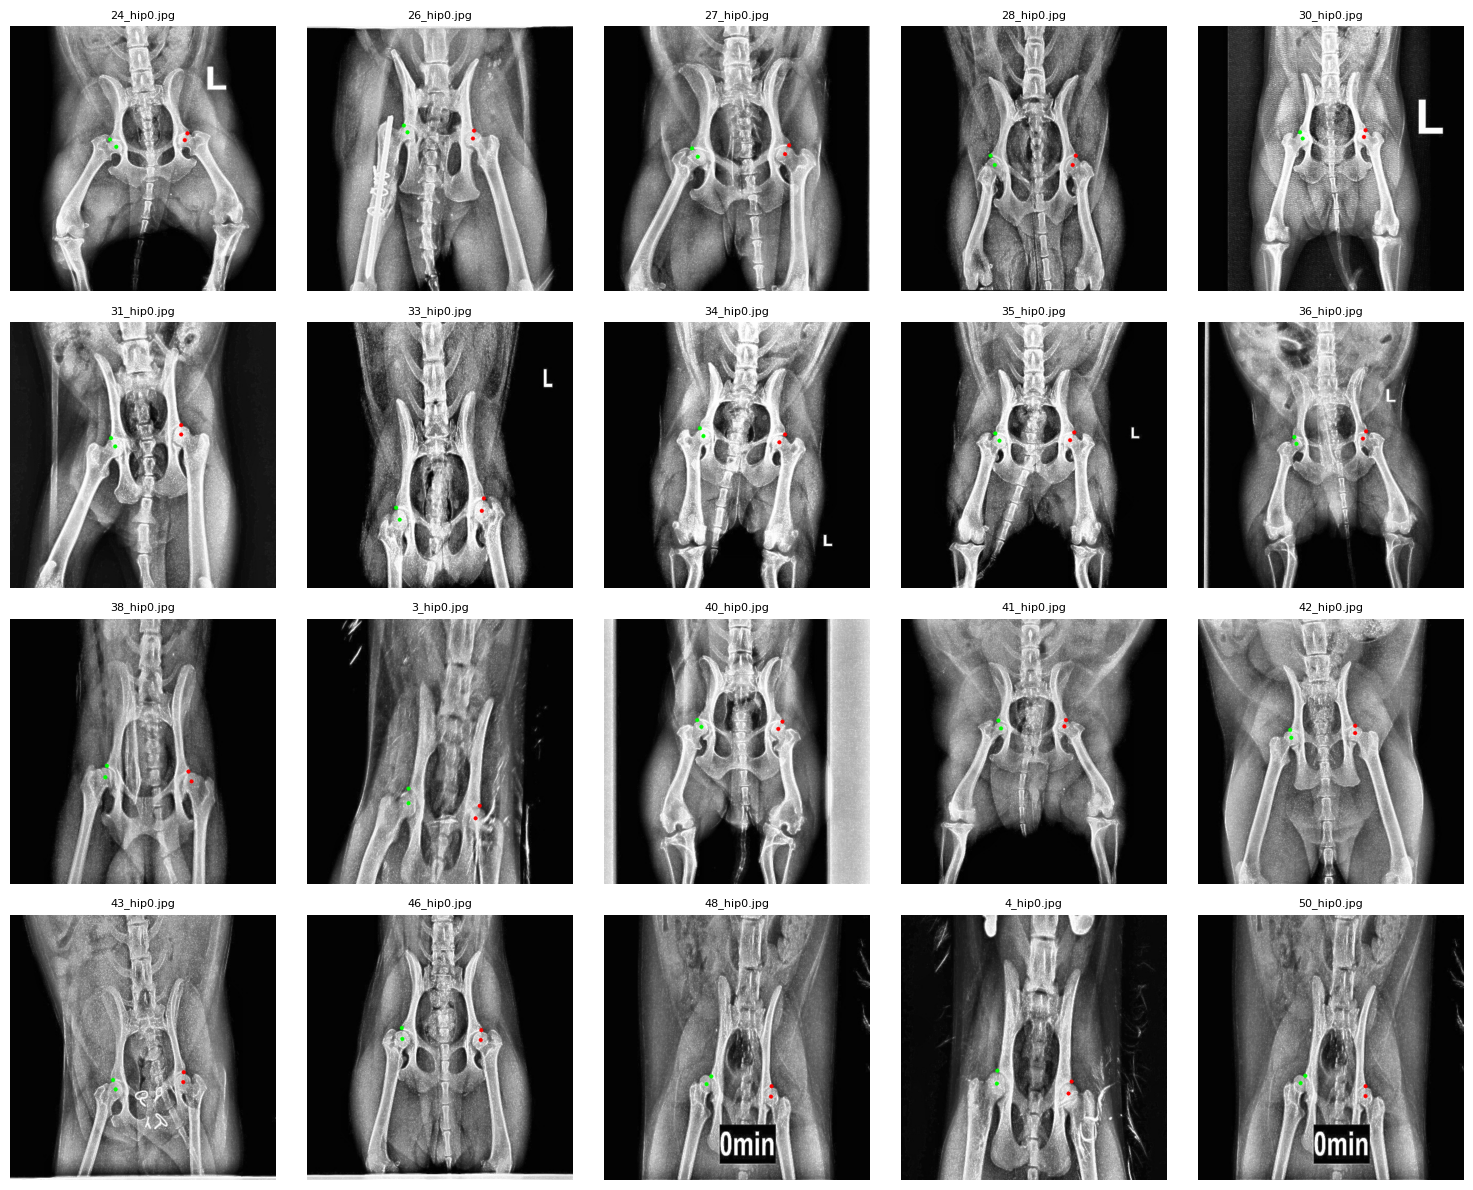

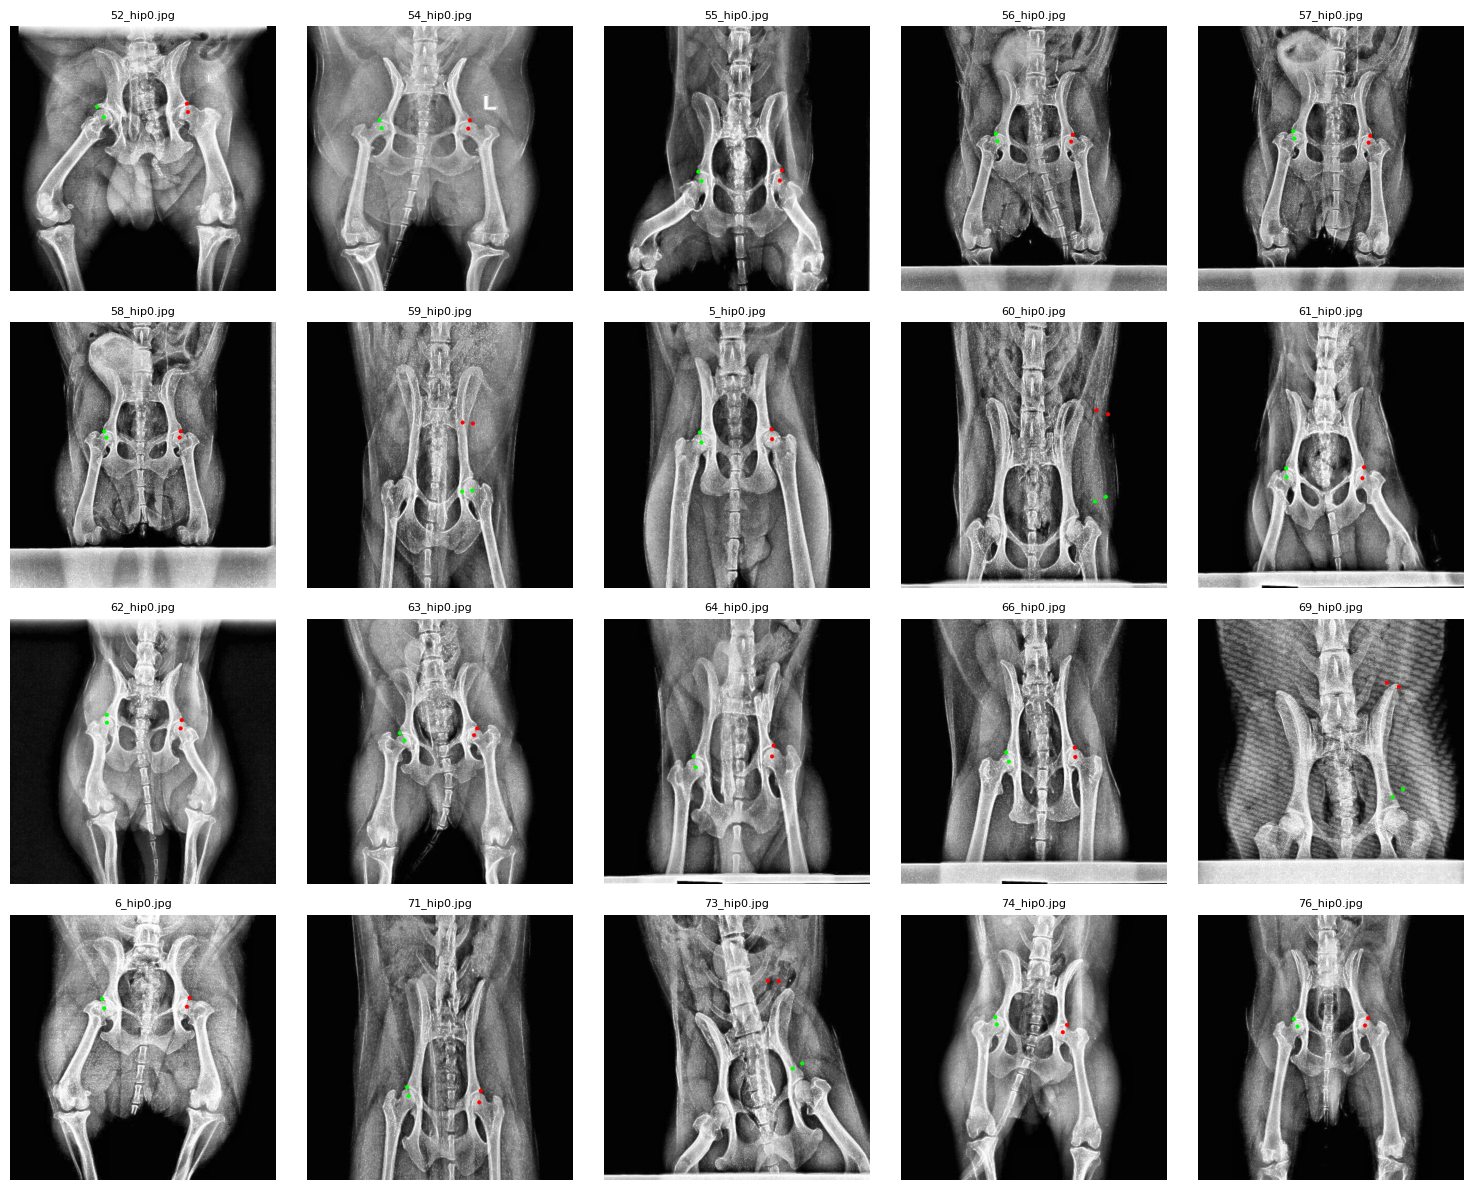

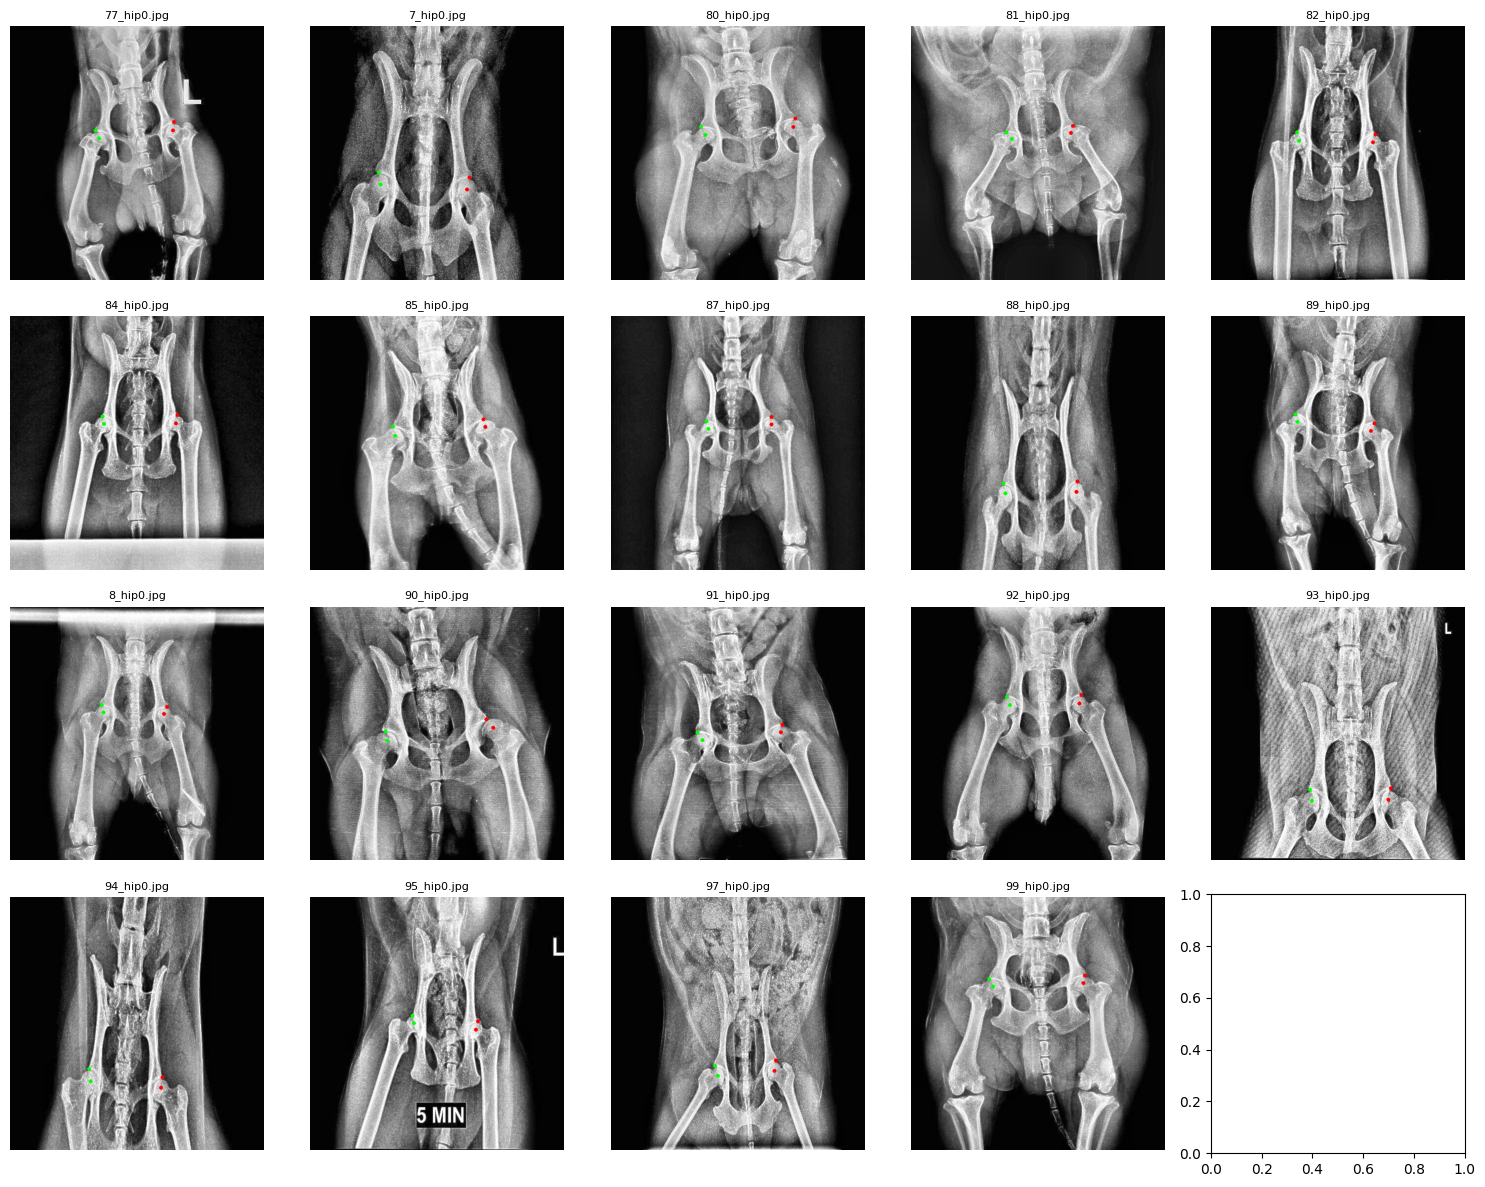

✅ GT Verification Complete — visually inspected all images.


In [ ]:
# Step 4: GT Annotations Viewer (Color-coded)
# Load fixed CSV
csv_path = csv_dir / "keypoints_normalized_FIXED.csv"
df_gt = pd.read_csv(csv_path)

IMG_SIZE = 512

def plot_batch(start_idx, batch_size=20):
    subset = df_gt.iloc[start_idx:start_idx+batch_size]
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, subset.iterrows()):
        img_path = images_dir / row['image_name']
        if not img_path.exists():
            ax.axis("off")
            continue

        img = cv2.imread(str(img_path))
        if img is None:
            ax.axis("off")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Left hip points — green
        left_points = [
            ('L_FHC_x', 'L_FHC_y'),
            ('L_CAR_x', 'L_CAR_y')
        ]
        for x_col, y_col in left_points:
            x = int(row[x_col] * IMG_SIZE)
            y = int(row[y_col] * IMG_SIZE)
            cv2.circle(img, (x, y), 4, (0, 255, 0), -1)

        # Right hip points — red
        right_points = [
            ('R_FHC_x', 'R_FHC_y'),
            ('R_CAR_x', 'R_CAR_y')
        ]
        for x_col, y_col in right_points:
            x = int(row[x_col] * IMG_SIZE)
            y = int(row[y_col] * IMG_SIZE)
            cv2.circle(img, (x, y), 4, (255, 0, 0), -1)

        ax.imshow(img)
        ax.set_title(row['image_name'], fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Display in batches
batch_size = 20
total = len(df_gt)
for start in range(0, total, batch_size):
    plot_batch(start, batch_size=batch_size)

print("✅ GT Verification Complete — visually inspected all images.")


In [ ]:
# Same thing for second 100 images
# Paths
BASE_DIR = Path(os.getcwd()).parent  
xml_file3 = BASE_DIR / "data" / "u110" / "annotations 5.xml" 
csv_output_dir = BASE_DIR / "data" / "u110"
csv_output_dir.mkdir(parents=True, exist_ok=True)

# Label map
LABEL_MAP = {
    "L_femoral_head_center": ("L_FHC_x", "L_FHC_y"),
    "R_femoral_head_center": ("R_FHC_x", "R_FHC_y"),
    "L_cranial_acetabular_rim": ("L_CAR_x", "L_CAR_y"),
    "R_cranial_acetabular_rim": ("R_CAR_x", "R_CAR_y"),
}

# Parsing helper 
def parse_cvat_points_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    records = []

    for image_tag in root.findall("image"):
        img_name = image_tag.attrib["name"]
        w = float(image_tag.attrib["width"])
        h = float(image_tag.attrib["height"])
        pts_tags = image_tag.findall("points")

        coords = {col: None for col_pair in LABEL_MAP.values() for col in col_pair}

        if len(pts_tags) == 1:
            coords_strs = pts_tags[0].attrib["points"].split(";")
            if len(coords_strs) != 4:
                continue
            ordered_labels = [
                "L_femoral_head_center",
                "R_femoral_head_center",
                "L_cranial_acetabular_rim",
                "R_cranial_acetabular_rim",
            ]
            for label, coord_str in zip(ordered_labels, coords_strs):
                x_str, y_str = coord_str.split(",")
                norm_x, norm_y = float(x_str) / w, float(y_str) / h
                x_col, y_col = LABEL_MAP[label]
                coords[x_col] = norm_x
                coords[y_col] = norm_y

        elif len(pts_tags) == 4:
            for pt in pts_tags:
                label = pt.attrib["label"]
                if label not in LABEL_MAP:
                    continue
                x_str, y_str = pt.attrib["points"].split(",")
                norm_x, norm_y = float(x_str) / w, float(y_str) / h
                x_col, y_col = LABEL_MAP[label]
                coords[x_col] = norm_x
                coords[y_col] = norm_y

        if all(v is not None for v in coords.values()):
            records.append({"image_name": img_name, **coords})

    return pd.DataFrame(records, columns=["image_name"] + [c for pair in LABEL_MAP.values() for c in pair])

# Parse XML 5 → CSV
df5 = parse_cvat_points_xml(xml_file3)

# optional sanity check
print(f"Found {len(df5)} complete annotations in annotations 5.xml")

output_csv_path = csv_output_dir / "keypoints_normalized_from_annotations5.csv"
df5.to_csv(output_csv_path, index=False)
print(f"✅ Saved CSV: {output_csv_path}")

# show sample rows
df5.sample(5)

Found 117 complete annotations in annotations 5.xml
✅ Saved CSV: /Users/aryan078/Desktop/CHD_project/outputs/csv/keypoints_normalized_from_annotations5.csv


image_name   L_FHC_x   L_FHC_y   R_FHC_x   R_FHC_y  \
13  Radiograph2 copy 11_hip0.jpg  0.411328  0.134570  0.680273  0.130859   
60  Radiograph2 copy 56_hip0.jpg  0.359180  0.430078  0.626953  0.445312   
93   Radiograph4 copy 2_hip0.jpg  0.295117  0.434375  0.598828  0.472852   
94   Radiograph4 copy 3_hip0.jpg  0.350000  0.399023  0.605078  0.487891   
42   Radiograph2 copy 3_hip0.jpg  0.314648  0.402148  0.613477  0.440625   

     L_CAR_x   L_CAR_y   R_CAR_x   R_CAR_y  
13  0.393945  0.096289  0.691992  0.089453  
60  0.346875  0.399414  0.641797  0.416211  
93  0.297070  0.405859  0.612305  0.445898  
94  0.361523  0.375781  0.625781  0.463867  
42  0.311914  0.371484  0.629102  0.411719